In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

import warnings
warnings.filterwarnings(action='ignore')

C:\Users\Datalab425\AppData\Local\Temp\ipykernel_51504\33567427.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import numpy as np

# optimizer
from tensorflow.keras import optimizers
# define model
from tensorflow.keras.models import Sequential, Model
# layer function(elements)1
from tensorflow.keras.layers import Conv1D, MaxPooling1D
# layer function(elements)2
from tensorflow.keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
# MSE loss function
from sklearn.metrics import mean_squared_error
# dateset split function
from sklearn.model_selection import train_test_split

%matplotlib inline
import tensorflow as tf
from numpy.random import seed
tf.random.set_seed(1)
seed(1)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


In [3]:
df = pd.read_csv('./dataset/ella/2023년 10월 엘니뇨 라니냐지수.csv')

df = df[['WTCH_YM','ENN_LNN_MNTH_AVG_VAL']]

df['WTCH_YM'] = pd.to_datetime(df['WTCH_YM'], format='%Y%m') # assume format YYYYMM
print(df.head())


     WTCH_YM  ENN_LNN_MNTH_AVG_VAL
0 1982-01-01             26.583536
1 1982-02-01             26.455164
2 1982-03-01             27.034367
3 1982-04-01             27.782887
4 1982-05-01             28.324877


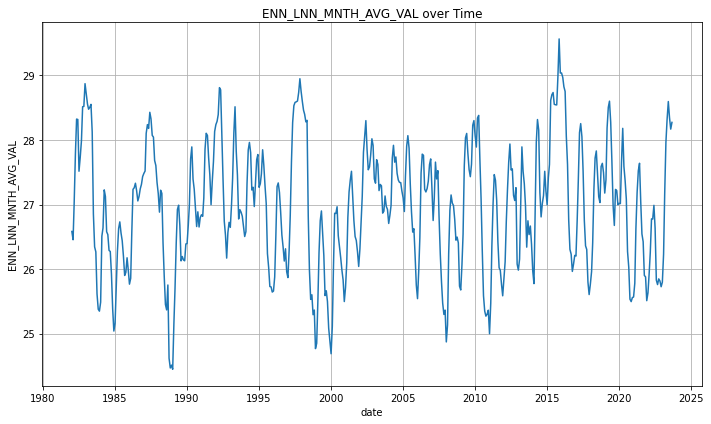

In [4]:
# drawing
plt.figure(figsize=(10, 6))
plt.plot(df.WTCH_YM, df.ENN_LNN_MNTH_AVG_VAL)
plt.xlabel('date')
plt.ylabel('ENN_LNN_MNTH_AVG_VAL')
plt.title('ENN_LNN_MNTH_AVG_VAL over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

In [5]:
train_df = df[df['WTCH_YM'] < '2020-01-01']
test_df = df[df['WTCH_YM'] >= '2020-01-01']

In [6]:
def make_series(data, window=1, dropnan=True):
    cols, names = [], []
    
    for i in range(window, 0, -1):
        cols.append(data.shift(i)) # shift: 행의 위치를 이동 [양수: 아래, 음수: 위]
        names += [f'{col_name}(t-{i})' for col_name in data.columns]
    
    cols.append(data)
    names += [f'{col}(t)' for col in data.columns]
    
    cols.append(data.shift(-1))
    names += [f'{col}(t+1)' for col in data.columns]
    
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [7]:
window = 11
series = make_series(train_df.drop('WTCH_YM', axis=1), window=window)
print(series.head())

labels_col = 'ENN_LNN_MNTH_AVG_VAL(t+1)' # label is t+1 
labels = series[labels_col]
series.drop(labels_col, axis=1, inplace=True)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print(X_train.head())

    ENN_LNN_MNTH_AVG_VAL(t-11)  ENN_LNN_MNTH_AVG_VAL(t-10)  ENN_LNN_MNTH_AVG_VAL(t-9)  ENN_LNN_MNTH_AVG_VAL(t-8)  ENN_LNN_MNTH_AVG_VAL(t-7)  ENN_LNN_MNTH_AVG_VAL(t-6)  ENN_LNN_MNTH_AVG_VAL(t-5)  ENN_LNN_MNTH_AVG_VAL(t-4)  ENN_LNN_MNTH_AVG_VAL(t-3)  ENN_LNN_MNTH_AVG_VAL(t-2)  ENN_LNN_MNTH_AVG_VAL(t-1)  ENN_LNN_MNTH_AVG_VAL(t)  ENN_LNN_MNTH_AVG_VAL(t+1)
11                   26.583536                   26.455164                  27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                28.873512                  28.718626
12                   26.455164                   27.034367                  27.782887                  28.324877                  28.318243                  27.516779                  27.732350                  27.988077                  28.516157                  28.520609                  

In [8]:
# given y_true, y_pred list, calculate r2, corr, mape, rmse than return result with df
def scoring(y_true, y_pred):
    r2 = round(metrics.r2_score(y_true, y_pred) * 100, 3)
    corr = round(np.corrcoef(y_true, y_pred)[0, 1], 3)
    mape = round(metrics.mean_absolute_percentage_error(y_true, y_pred) * 100, 3)
    rmse = round(metrics.mean_squared_error(y_true, y_pred, squared=False), 3)
    
    df = pd.DataFrame({
        'R2': r2,
        "Corr": corr,
        "RMSE": rmse,
        "MAPE": mape
    }, index=[0]) # 1행 데이터이므로 index를 0 하나만 부여
    return df

In [9]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
    
def MinMax(y_true, y_pred, m='min'):
    if m == 'min':
        return min(min(y_true), min(y_pred)) - 2
    else:
        return max(max(y_true), max(y_pred)) + 2
    
# x = date, y = MeanTemp
def myGraph(temp, title):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5), gridspec_kw={'width_ratios': [2.5, 1]})
    axs[0].plot(temp['WTCH_YM'], temp['y_true'], label = 'Original')
    axs[0].plot(temp['WTCH_YM'], temp['y_pred'], label = 'Predicted')
    axs[0].legend(loc='upper right')
    axs[0].title.set_text(title)
    axs[0].set_xlabel('WTCH_YM')
    axs[0].set_ylabel('ENN_LNN_MNTH_AVG_VAL')
    
    axs[1].plot(temp.y_true, temp.y_pred, '.')
    plt.xlim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    plt.ylim(MinMax(temp.y_true, temp.y_pred), MinMax(temp.y_true, temp.y_pred, 'max'))
    abline(1,0)
    plt.title(title)
    plt.xlabel('Original')
    plt.ylabel('Predicted')
    

In [19]:
epochs = 500
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

#(n, 12) -> (n, 12, 1)
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))

subsequences = 2
timesteps = X_train_series.shape[1] // subsequences
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))

In [16]:
X_train_series_sub[0][0]

array([[27.031288],
       [27.589138],
       [27.639217],
       [27.493692],
       [27.178534],
       [27.386492]])

# CNN + LSTM

In [18]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50,activation='relu'))
model_cnn_lstm.add(Dense(1))

model_cnn_lstm.compile(loss='mse', optimizer=adam)
model_cnn_lstm.summary()

variables = model_cnn_lstm.trainable_variables


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_1 (TimeDis  (None, None, 6, 64)      128       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, None, 3, 64)      0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, None, 192)        0         
 tributed)                                                       
                                                                 
 lstm (LSTM)                 (None, 50)                48600     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                      

In [21]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)

Y_train_ = pd.DataFrame({'y_true': Y_train, 'y_pred': cnn_lstm_train_pred.reshape(cnn_lstm_train_pred.shape[0],)}).set_index(X_train.index).sort_index()
#merge by using index
Y_train_ = pd.merge(Y_train_, train_df, left_index=True, right_index=True, how='left')

Y_valid_ = pd.DataFrame({'y_true': Y_valid, 'y_pred': cnn_lstm_valid_pred.reshape(cnn_lstm_valid_pred.shape[0],)}).set_index(X_valid.index).sort_index()
Y_valid_ = pd.merge(Y_valid_, train_df, left_index=True, right_index=True, how='left')

Epoch 1/500
9/9 - 3s - loss: 742.4204 - val_loss: 651.8809 - 3s/epoch - 382ms/step
Epoch 2/500
9/9 - 0s - loss: 589.5812 - val_loss: 499.2112 - 96ms/epoch - 11ms/step
Epoch 3/500
9/9 - 0s - loss: 425.3374 - val_loss: 311.6581 - 95ms/epoch - 11ms/step
Epoch 4/500
9/9 - 0s - loss: 234.2314 - val_loss: 130.8673 - 94ms/epoch - 10ms/step
Epoch 5/500
9/9 - 0s - loss: 80.9913 - val_loss: 27.3941 - 96ms/epoch - 11ms/step
Epoch 6/500
9/9 - 0s - loss: 12.2876 - val_loss: 1.0205 - 98ms/epoch - 11ms/step
Epoch 7/500
9/9 - 0s - loss: 1.9921 - val_loss: 4.7297 - 94ms/epoch - 10ms/step
Epoch 8/500
9/9 - 0s - loss: 4.2792 - val_loss: 3.3121 - 95ms/epoch - 11ms/step
Epoch 9/500
9/9 - 0s - loss: 1.9472 - val_loss: 1.1713 - 95ms/epoch - 11ms/step
Epoch 10/500
9/9 - 0s - loss: 0.8487 - val_loss: 0.9421 - 98ms/epoch - 11ms/step
Epoch 11/500
9/9 - 0s - loss: 0.9445 - val_loss: 1.0098 - 102ms/epoch - 11ms/step
Epoch 12/500
9/9 - 0s - loss: 0.9257 - val_loss: 0.9245 - 99ms/epoch - 11ms/step
Epoch 13/500
9/9 -

Epoch 101/500
9/9 - 0s - loss: 0.7535 - val_loss: 0.8409 - 124ms/epoch - 14ms/step
Epoch 102/500
9/9 - 0s - loss: 0.7578 - val_loss: 0.8411 - 112ms/epoch - 12ms/step
Epoch 103/500
9/9 - 0s - loss: 0.7550 - val_loss: 0.8397 - 111ms/epoch - 12ms/step
Epoch 104/500
9/9 - 0s - loss: 0.7542 - val_loss: 0.8454 - 110ms/epoch - 12ms/step
Epoch 105/500
9/9 - 0s - loss: 0.7473 - val_loss: 0.8351 - 113ms/epoch - 13ms/step
Epoch 106/500
9/9 - 0s - loss: 0.7517 - val_loss: 0.8396 - 116ms/epoch - 13ms/step
Epoch 107/500
9/9 - 0s - loss: 0.7500 - val_loss: 0.8438 - 115ms/epoch - 13ms/step
Epoch 108/500
9/9 - 0s - loss: 0.7538 - val_loss: 0.8437 - 114ms/epoch - 13ms/step
Epoch 109/500
9/9 - 0s - loss: 0.7497 - val_loss: 0.8297 - 113ms/epoch - 13ms/step
Epoch 110/500
9/9 - 0s - loss: 0.7491 - val_loss: 0.8359 - 111ms/epoch - 12ms/step
Epoch 111/500
9/9 - 0s - loss: 0.7424 - val_loss: 0.8338 - 109ms/epoch - 12ms/step
Epoch 112/500
9/9 - 0s - loss: 0.7408 - val_loss: 0.8334 - 112ms/epoch - 12ms/step
Epoc

Epoch 200/500
9/9 - 0s - loss: 0.2667 - val_loss: 0.2944 - 115ms/epoch - 13ms/step
Epoch 201/500
9/9 - 0s - loss: 0.2517 - val_loss: 0.3660 - 115ms/epoch - 13ms/step
Epoch 202/500
9/9 - 0s - loss: 0.2664 - val_loss: 0.2912 - 118ms/epoch - 13ms/step
Epoch 203/500
9/9 - 0s - loss: 0.2490 - val_loss: 0.2935 - 121ms/epoch - 13ms/step
Epoch 204/500
9/9 - 0s - loss: 0.2521 - val_loss: 0.2972 - 118ms/epoch - 13ms/step
Epoch 205/500
9/9 - 0s - loss: 0.2508 - val_loss: 0.3372 - 113ms/epoch - 13ms/step
Epoch 206/500
9/9 - 0s - loss: 0.2637 - val_loss: 0.2887 - 114ms/epoch - 13ms/step
Epoch 207/500
9/9 - 0s - loss: 0.2496 - val_loss: 0.2872 - 120ms/epoch - 13ms/step
Epoch 208/500
9/9 - 0s - loss: 0.2593 - val_loss: 0.2867 - 120ms/epoch - 13ms/step
Epoch 209/500
9/9 - 0s - loss: 0.2536 - val_loss: 0.2859 - 120ms/epoch - 13ms/step
Epoch 210/500
9/9 - 0s - loss: 0.2522 - val_loss: 0.2855 - 118ms/epoch - 13ms/step
Epoch 211/500
9/9 - 0s - loss: 0.2488 - val_loss: 0.2874 - 120ms/epoch - 13ms/step
Epoc

Epoch 299/500
9/9 - 0s - loss: 0.2512 - val_loss: 0.2683 - 120ms/epoch - 13ms/step
Epoch 300/500
9/9 - 0s - loss: 0.2329 - val_loss: 0.3523 - 113ms/epoch - 13ms/step
Epoch 301/500
9/9 - 0s - loss: 0.2623 - val_loss: 0.3479 - 119ms/epoch - 13ms/step
Epoch 302/500
9/9 - 0s - loss: 0.2502 - val_loss: 0.3076 - 121ms/epoch - 13ms/step
Epoch 303/500
9/9 - 0s - loss: 0.2324 - val_loss: 0.2610 - 155ms/epoch - 17ms/step
Epoch 304/500
9/9 - 0s - loss: 0.2274 - val_loss: 0.2619 - 128ms/epoch - 14ms/step
Epoch 305/500
9/9 - 0s - loss: 0.2325 - val_loss: 0.2594 - 112ms/epoch - 12ms/step
Epoch 306/500
9/9 - 0s - loss: 0.2744 - val_loss: 0.3796 - 111ms/epoch - 12ms/step
Epoch 307/500
9/9 - 0s - loss: 0.2377 - val_loss: 0.2809 - 112ms/epoch - 12ms/step
Epoch 308/500
9/9 - 0s - loss: 0.2341 - val_loss: 0.2589 - 109ms/epoch - 12ms/step
Epoch 309/500
9/9 - 0s - loss: 0.2352 - val_loss: 0.2632 - 116ms/epoch - 13ms/step
Epoch 310/500
9/9 - 0s - loss: 0.2224 - val_loss: 0.2658 - 113ms/epoch - 13ms/step
Epoc

Epoch 398/500
9/9 - 0s - loss: 0.2563 - val_loss: 0.2514 - 125ms/epoch - 14ms/step
Epoch 399/500
9/9 - 0s - loss: 0.2310 - val_loss: 0.2564 - 115ms/epoch - 13ms/step
Epoch 400/500
9/9 - 0s - loss: 0.2500 - val_loss: 0.3196 - 114ms/epoch - 13ms/step
Epoch 401/500
9/9 - 0s - loss: 0.2793 - val_loss: 0.3290 - 121ms/epoch - 13ms/step
Epoch 402/500
9/9 - 0s - loss: 0.2625 - val_loss: 0.2559 - 122ms/epoch - 14ms/step
Epoch 403/500
9/9 - 0s - loss: 0.2806 - val_loss: 0.2515 - 123ms/epoch - 14ms/step
Epoch 404/500
9/9 - 0s - loss: 0.2338 - val_loss: 0.2600 - 113ms/epoch - 13ms/step
Epoch 405/500
9/9 - 0s - loss: 0.2095 - val_loss: 0.2840 - 115ms/epoch - 13ms/step
Epoch 406/500
9/9 - 0s - loss: 0.2133 - val_loss: 0.2487 - 123ms/epoch - 14ms/step
Epoch 407/500
9/9 - 0s - loss: 0.2183 - val_loss: 0.2682 - 123ms/epoch - 14ms/step
Epoch 408/500
9/9 - 0s - loss: 0.2126 - val_loss: 0.2479 - 117ms/epoch - 13ms/step
Epoch 409/500
9/9 - 0s - loss: 0.2171 - val_loss: 0.2544 - 116ms/epoch - 13ms/step
Epoc

9/9 - 0s - loss: 0.2122 - val_loss: 0.2547 - 119ms/epoch - 13ms/step
Epoch 498/500
9/9 - 0s - loss: 0.2528 - val_loss: 0.2457 - 113ms/epoch - 13ms/step
Epoch 499/500
9/9 - 0s - loss: 0.2625 - val_loss: 0.2406 - 116ms/epoch - 13ms/step
Epoch 500/500
9/9 - 0s - loss: 0.2637 - val_loss: 0.3514 - 112ms/epoch - 12ms/step


In [22]:
scoring(Y_train_.y_true, Y_train_.y_pred)

,R2,Corr,RMSE,MAPE
0,73.482,0.893,0.511,1.484


In [23]:
scoring(Y_valid_.y_true, Y_valid_.y_pred)

,R2,Corr,RMSE,MAPE
0,60.35,0.855,0.593,1.648


Obs of Valid Set:  178


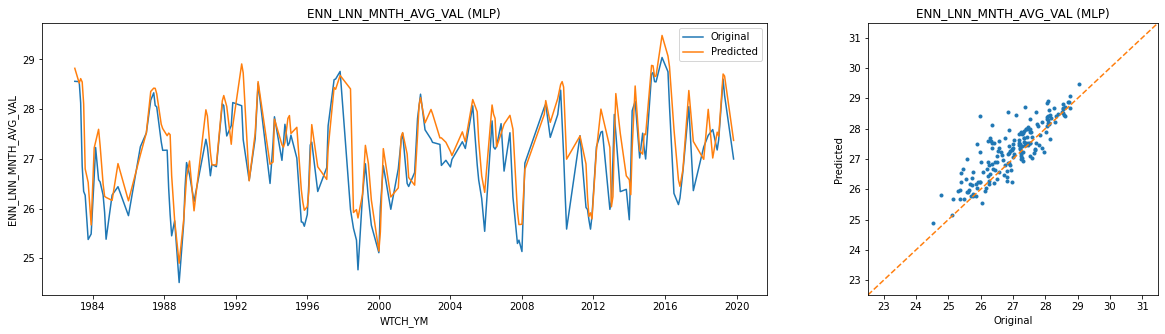

In [24]:
print('Obs of Valid Set: ', Y_valid_.shape[0])
myGraph(Y_valid_, 'ENN_LNN_MNTH_AVG_VAL (MLP)')

# TEST

In [28]:
test_series = make_series(test_df.drop('WTCH_YM', axis=1), window=window)
test_labels = test_series[labels_col]
test_series = test_series.drop(labels_col, axis=1)

X_test = test_series
X_test_series = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

subsequences = 2
timesteps = X_test_series.shape[1] // subsequences
X_test_series_sub = X_test_series.reshape((X_test_series.shape[0], subsequences, timesteps, 1))

Y_test = test_labels.values

cnn_lstm_test_pred = model_cnn_lstm.predict(X_test_series_sub)

Y_test_ = pd.DataFrame({'y_true': Y_test, 'y_pred': cnn_lstm_test_pred.reshape(cnn_lstm_test_pred.shape[0],)}).set_index(X_test.index).sort_index()
Y_test_ = pd.merge(Y_test_, test_df, left_index=True, right_index=True, how='left')

scoring(Y_test_.y_true, Y_test_.y_pred)

,R2,Corr,RMSE,MAPE
0,77.757,0.9,0.445,1.247


Obs of Test Set:  33


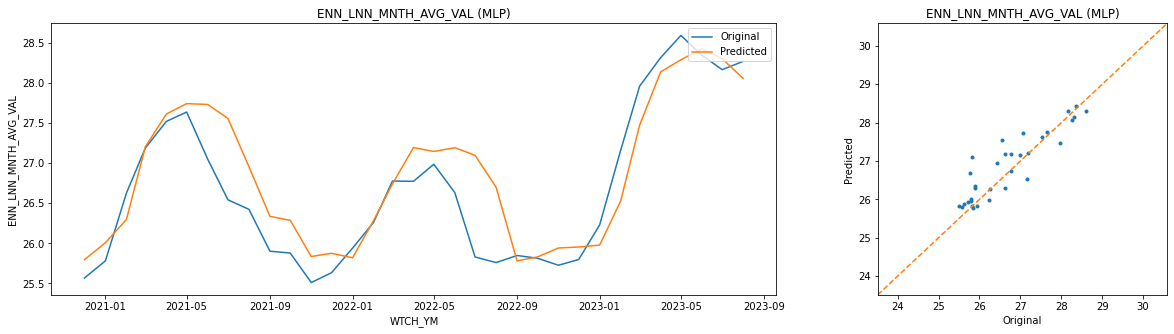

In [29]:
print('Obs of Test Set: ', Y_test_.shape[0])
myGraph(Y_test_, 'ENN_LNN_MNTH_AVG_VAL (MLP)')